In [1]:
import os
import numpy as np
import cv2

In [2]:
imgDirectory = 'D:\Secured Home\SecuredHome\Project Files\Datasets\Face Mask Dataset'
categories = ['with_mask', 'without_mask']
data= []
labels = []

## Preparing data

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

for category in categories:
    path = os.path.join(imgDirectory, category)
    for imgName in os.listdir(path):
        img = cv2.imread(os.path.join(path, imgName))
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgRGB = cv2.resize(imgRGB, (224, 224))
        imgRGB = np.array(imgRGB)
        imgRGB = preprocess_input(imgRGB)
        data.append(imgRGB)
        labels.append(category)

Performing One-hot Encoding.

In [4]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)
print()
print()
labels = to_categorical(labels)

print(labels)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [5]:
data = np.array(data, dtype='float32')
labels = np.array(labels)

In [6]:
print(len(data))

7553


Splitting the data into training, validation and testing set.

In [7]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
xTest, xVal, yTest, yVal = train_test_split(xTest, yTest, test_size=0.5, random_state=42)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
print(xVal.shape)
print(yVal.shape)

(5287, 224, 224, 3)
(5287, 2)
(1133, 224, 224, 3)
(1133, 2)
(1133, 224, 224, 3)
(1133, 2)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode = 'nearest')

## Data Visualization

In [9]:
samples = []
c = 0

for i in range(0, len(categories)):
    for j in range(0, yTrain.shape[0]):
        if yTrain[j][i] == 1:
            c +=1
    print(f"The number of image {categories[i]} in training set = {c}")
    samples.append(c)
    c = 0

The number of image with_mask in training set = 2607
The number of image without_mask in training set = 2680


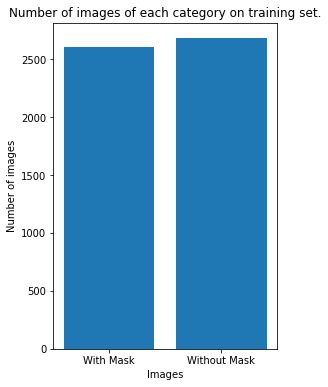

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 6))
plt.bar(['With Mask', 'Without Mask'], samples)
plt.title("Number of images of each category on training set.")
plt.xlabel("Images")
plt.ylabel("Number of images")
plt.show()

In [11]:
samples = []
c = 0

for i in range(0, len(categories)):
    for j in range(0, yVal.shape[0]):
        if yVal[j][i] == 1:
            c +=1
    print(f"The number of image {categories[i]} in testing/validation set = {c}")
    samples.append(c)
    c = 0

The number of image with_mask in testing/validation set = 562
The number of image without_mask in testing/validation set = 571


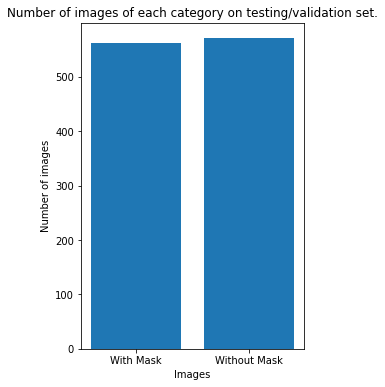

In [12]:
plt.figure(figsize=(4, 6))
plt.bar(['With Mask', 'Without Mask'], samples)
plt.title("Number of images of each category on testing/validation set.")
plt.xlabel("Images")
plt.ylabel("Number of images")
plt.show()

c:\users\dipin\appdata\local\programs\python\python37\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


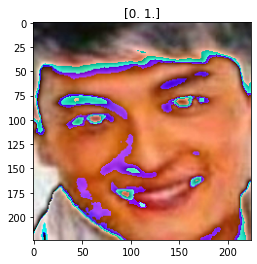

In [13]:
plt.imshow((xTrain[0]*255).astype(np.uint8))
plt.title(yTrain[0])
plt.show()

Applying Image Augmentation to increase the training dataset by applying various transformations to the original images.

## Training Data

Using MobileNetV2 CNN architecture with pretrained weights from the ImageNet dataset. The fully connnected layers responsible for classification are not included as we are using transfer learning.

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

baseModel = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

Adding additional layers on top of the base MobileNetV2 model, creating a custom classification head for a specific task. 

In [15]:
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

In [16]:
from tensorflow.keras.models import Model

model = Model(inputs=baseModel.input, outputs=headModel)

Sets the trainable attribute of the baseModel to False as we are using the pre-trained model as a feature extractor and only train the custom classification head.

In [17]:
for layer in baseModel.layers:
    layer.trainable = False

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [19]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

Early Stopping helps prevent overfitting by stopping training when the modified metric ('val_accuracy') stops improving, thus avoiding unnecessary epochs.

ModelCheckpoint saves the weights of the best-performing model based on the monitored metic('val_accuracy'), allowing us to restore the best model.

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.001, patience= 5, verbose=1)
mc = ModelCheckpoint(filepath="Face Mask Recognition Model.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

Training the data

In [21]:
hist = model.fit(
        aug.flow(xTrain, yTrain, batch_size=32),
        epochs=20,
        steps_per_epoch=15,
        validation_data=(xVal, yVal),
        callbacks=[es, mc])

Epoch 1/20
15/15 [==============================] - 37s 2s/step - loss: 0.3240 - accuracy: 0.8771 - val_loss: 0.0654 - val_accuracy: 0.9832

Epoch 00001: val_accuracy improved from -inf to 0.98323, saving model to Face Mask Recognition Model.h5


c:\users\dipin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
15/15 [==============================] - 32s 2s/step - loss: 0.0942 - accuracy: 0.9729 - val_loss: 0.0377 - val_accuracy: 0.9876

Epoch 00002: val_accuracy improved from 0.98323 to 0.98764, saving model to Face Mask Recognition Model.h5
Epoch 3/20
15/15 [==============================] - 31s 2s/step - loss: 0.0768 - accuracy: 0.9708 - val_loss: 0.0422 - val_accuracy: 0.9868

Epoch 00003: val_accuracy did not improve from 0.98764
Epoch 4/20
15/15 [==============================] - 31s 2s/step - loss: 0.0575 - accuracy: 0.9780 - val_loss: 0.0838 - val_accuracy: 0.9718

Epoch 00004: val_accuracy did not improve from 0.98764
Epoch 5/20
15/15 [==============================] - 31s 2s/step - loss: 0.0779 - accuracy: 0.9736 - val_loss: 0.0361 - val_accuracy: 0.9894

Epoch 00005: val_accuracy improved from 0.98764 to 0.98941, saving model to Face Mask Recognition Model.h5
Epoch 6/20
15/15 [==============================] - 33s 2s/step - loss: 0.0458 - accuracy: 0.9833 - val_loss: 0.

In [22]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

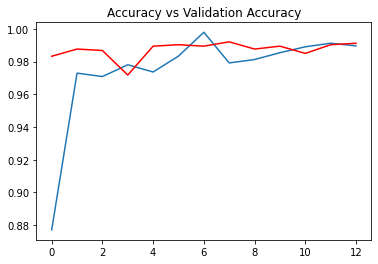

In [23]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("Accuracy vs Validation Accuracy")
plt.show()

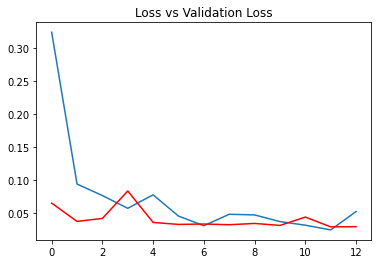

In [24]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("Loss vs Validation Loss")
plt.show()

## Evaluating Model

In [25]:
from tensorflow.keras.models import load_model
model = load_model("Face Mask Detection Model.h5")

In [26]:
acc = model.evaluate(xTrain, yTrain)[1] 

print(f"The accuracy of our model is = {acc} %")

166/166 [==============================] - 126s 753ms/step - loss: 0.0302 - accuracy: 0.9883
The accuracy of our model is = 0.9882731437683105 %


Predicting the values of xTest

In [27]:
yTestPred = []
for i in range(0, xTest.shape[0]):
    img = xTest[i]
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgRGB = cv2.resize(img, (224, 224))
    imgA = np.array(imgRGB)
    imgF = np.expand_dims(imgA, axis=0)
    prediction = model.predict(imgF)
    prediction = np.argmax(prediction, axis=1)
    yTestPred.append(prediction)

yTestPred = np.array(yTestPred)

In [28]:
yTestPred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int64)

### Confusion Matrix


It is a table that evaluates the performance of a classification model by comparing predicted labels with true labels, providing counts of true positives, true negatives, false positives, and false negatives.

In [29]:
from sklearn.metrics import confusion_matrix

yTestPred = np.reshape(yTestPred, (1133,))
confusionMatrix = confusion_matrix(np.argmax(yTest, axis=1), yTestPred)

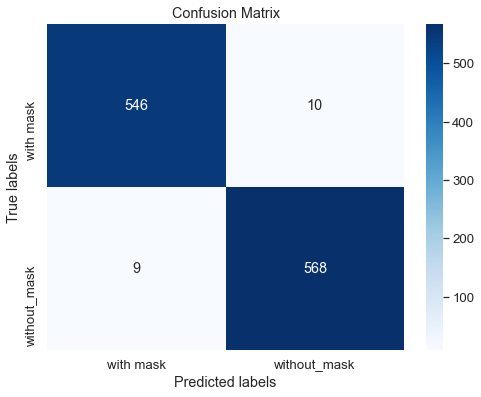

In [30]:
import seaborn as sns

class_names = ['with mask', 'without_mask'] 

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusionMatrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
incorrectPred = np.where(yTestPred != np.argmax(yTest, axis=1))[0]
print(incorrectPred)

[  25   72  103  110  185  227  497  536  556  597  723  747  833  878
  929  976 1055 1083 1105]


#### Visualizing incorrectly predicted images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

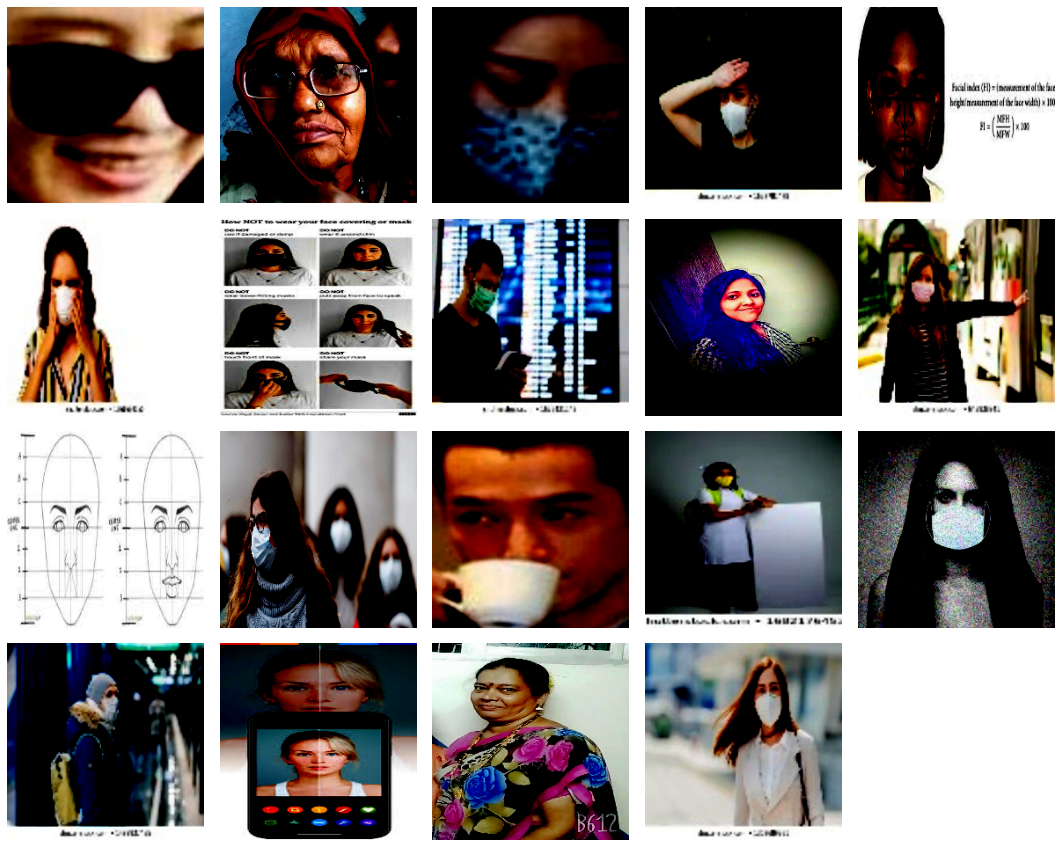

In [61]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()
for i in range(len(incorrectPred)):
    axes[i].imshow(xTest[incorrectPred[i]])
    axes[i].axis('off')

for j in range(len(incorrectPred), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Precision, Recall and F1-score

Precision answers off all the predicted positive, how much are actually positive. Precision = TP/(TP + FP).

Recall answers of all the positives, how much are predicted positive. Recall = TP/(TP + FN).

F-1 score is the harmonic mean of precision and recall.

In [62]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(np.argmax(yTest, axis=1), yTestPred)
recall = recall_score(np.argmax(yTest, axis=1), yTestPred)
print(f"Precision is {precision} and recall is {recall}.")

Precision is 0.9826989619377162 and recall is 0.9844020797227037.


In [63]:
from sklearn.metrics import f1_score

f1Score = f1_score(np.argmax(yTest, axis=1), yTestPred)
print(f"F1 Score is {f1Score}.")

F1 Score is 0.9835497835497834.


In [64]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(np.argmax(yTest, axis=1), yTestPred)

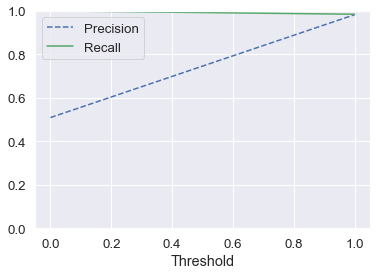

In [65]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### ROC Curve

ROC curve plots the true positive rate(recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. FPR = 1 - TNR(specificity). Area under the curve near to 1 is good for a classifier. It's like plotting precision versus recall.

In [66]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(np.argmax(yTest, axis=1), yTestPred)

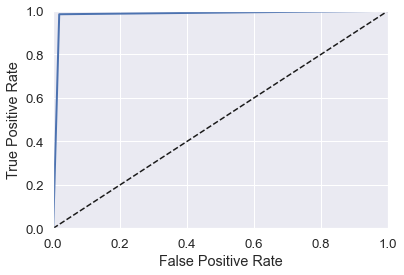

In [67]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [68]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(np.argmax(yTest, axis=1), yTestPred))

0.9832082341059561
